In [ ]:
!pip install pypdf
!pip install -q transformers einops accelerate langchain bitsandbytes
!pip install sentence_transformers
!pip install llama_index
!pip install llama-index-llms-huggingface
!pip install -U langchain-community
!pip install llama-index-embeddings-langchain
!pip install bitsandbytes
!pip install rouge_score
!pip install evaluate datasets
!pip install bert-score
!pip install sacrebleu

In [ ]:
from llama_index.core import VectorStoreIndex, Document
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core.prompts import PromptTemplate
from llama_index.core.query_engine import RetryQueryEngine
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Settings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from llama_index.core.indices.query.query_transform import HyDEQueryTransform
from tenacity import retry, stop_after_attempt, wait_exponential
from llama_index.core.prompts.prompts import SimpleInputPrompt
from llama_index.core import SimpleDirectoryReader

import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from tenacity import retry, stop_after_attempt, wait_exponential

In [ ]:
class DataLoader:
    """Handles loading research papers from the given directory."""
    def __init__(self, directory_path):
        self.directory_path = directory_path

    def load_documents(self):
        return SimpleDirectoryReader(self.directory_path).load_data()

In [ ]:
class ModelLoader:
    """Loads the LLM model, tokenizer, and embedding model."""
    def __init__(self, model_name, quantization_config=None, max_tokens=512, temperature=0.2, top_k=40, top_p=0.95): #set params here
        self.model_name = model_name
        self.quantization_config = quantization_config
        self.max_tokens = max_tokens
        self.temperature = temperature
        self.top_k = top_k
        self.top_p = top_p

    def load_model_and_tokenizer(self):
        tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            quantization_config=self.quantization_config,
            device_map="auto",
        )
        return model, tokenizer

    def initialize_llm(self, model, tokenizer):
        return HuggingFaceLLM(
            context_window=2048,
            max_new_tokens=self.max_tokens,
            model=model,
            tokenizer=tokenizer,
            generate_kwargs={
                "temperature": self.temperature,
                "do_sample": True,
                "top_k": self.top_k,
                "top_p": self.top_p,
            },
            device_map="auto",
            tokenizer_kwargs={"clean_up_tokenization_spaces": True},
        )

    def load_embedding_model(self, embedding_model_name="sentence-transformers/all-MiniLM-L6-v2"):
        return HuggingFaceEmbeddings(model_name=embedding_model_name)

In [ ]:
class Indexer:
    """Creates an index from the loaded documents."""
    def __init__(self, llm, embed_model, chunk_size=1024, chunk_overlap=40):
        self.llm = llm
        self.embed_model = embed_model
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap # 40 as it helps to retain context across chunks

    def create_index(self, documents):
        Settings.llm = self.llm
        Settings.embed_model = self.embed_model
        Settings.node_parser = SentenceSplitter(chunk_size=self.chunk_size, chunk_overlap=self.chunk_overlap)
        return VectorStoreIndex.from_documents(documents)

In [ ]:
!pip install -U :class:`~langchain-huggingface

/bin/bash: -c: line 1: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [ ]:
!pip install docx2txt

  Preparing metadata (setup.py) ... done
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3960 sha256=e1373e8a054c894f7f4c0369272a6340015c38858de1b7a6cf8535ba551e1993
  Stored in directory: /root/.cache/pip/wheels/22/58/cf/093d0a6c3ecfdfc5f6ddd5524043b88e59a9a199cb02352966
Successfully built docx2txt


In [ ]:
from huggingface_hub import login
import os
from transformers import BitsAndBytesConfig

os.environ['HF_TOKEN'] = 'token'
login(token=os.environ['HF_TOKEN'])

# Data loading
data_loader = DataLoader("/content/Data")
documents = data_loader.load_documents()

# Model initialization
model_name = "meta-llama/Llama-2-7b-chat-hf"
# model_name = "google/gemma-7b"
# model_name = "meta-llama/Llama-3.2-1B"

#quantizing the model
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model_loader = ModelLoader(model_name, quant_config)
model, tokenizer = model_loader.load_model_and_tokenizer()
llm = model_loader.initialize_llm(model, tokenizer)
embed_model = model_loader.load_embedding_model()

# Index creation
indexer = Indexer(llm, embed_model)
index = indexer.create_index(documents)

print("Model and index initialized successfully!")


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model and index initialized successfully!


In [ ]:
class AgenticRAG:
    def __init__(self, index):
        self.index = index
        self.hyde = HyDEQueryTransform(include_original=True)

    def reformulate_query(self, query):
    # Reformulate the user's question to focus on key factors related to CNT synthesis.
        prompt = PromptTemplate(
            "The user's query is about carbon nanotube (CNT) synthesis experiments: '{query}'\n"
            "Reformulate this query to focus on the key experimental factors that influence CNT growth, such as temperature, catalyst type, catalyst thickness, and growth rate. "
            "Ensure the query is simplified and clear, maintaining focus on understanding how these factors affect the final CNT growth height, rate, and quality. "
            "The reformulated query should be easy for a novice researcher to understand and directly related to experimental setups and results."
            "Reformulated query: "
        )

        response = llm.complete(prompt.format(query=query))
        return response.text.strip()

    def search_and_retrieve(self, query):
        # Use HyDE to generate a search query and retrieve relevant research data.
        query_engine = self.index.as_query_engine()
        hyde_query = self.hyde(query)
        return query_engine.query(hyde_query)

    def analyze_results(self, results):
    # Analyze retrieved research results, focusing on relevant parameters and their impact on CNT synthesis.
        prompt = PromptTemplate(
            "Analyze the following experimental results on CNT synthesis:\n{results}\n"
            "- Summarize the key findings from these experiments, emphasizing the effects of temperature, catalyst type (e.g., Fe, Al2O3), and catalyst thickness on CNT growth rate and final height.\n"
            "- Highlight any optimal temperature ranges, the most effective catalysts, and how the catalyst thickness or type affects the overall CNT growth and quality.\n"
            "- Provide simple, practical suggestions for improving CNT synthesis experiments, including numerical examples and key insights from the retrieved results.\n"
            "Analysis:"
        )

        response = llm.complete(prompt.format(results=str(results)))
        return response.text

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
    def generate_final_answer(self, context, original_query):
        # Generate the final answer with specific focus on parameters like temperature, catalyst type, and growth rate.
          prompt = PromptTemplate(
            "The user is asking about CNT synthesis and how parameters like temperature, catalyst type, and growth rate affect CNT growth. "
            "Context: {context}\n"
            "Provide a clear and accessible explanation, using the retrieved experimental results, on how temperature, catalyst type (e.g., Fe, Al2O3), and growth rate influence CNT growth height, rate, and overall quality. "
            "Explain the relationship between these factors, and include any numerical data or examples from the experiments, such as optimal temperature ranges, growth rates, and catalyst thicknesses. "
            "Offer practical suggestions for a novice researcher, including potential experimental adjustments to optimize CNT synthesis."
        )
          response = llm.complete(prompt.format(context=context, original_query=original_query))
          return response.text

    def process_query(self, initial_query):
        # Reformulate, retrieve, and generate the final answer based on the user query and research context.
        refined_query = self.reformulate_query(initial_query)
        print(f"Refined Query: {refined_query}")

        results = self.search_and_retrieve(refined_query)
        print(f"Retrieved Results: {results}")

        final_answer = self.generate_final_answer(results, initial_query)
        print(f"Final Answer: {final_answer}")

        return final_answer


Updated prompts

In [ ]:
class AgenticRAG:
    def __init__(self, index):
        self.index = index
        self.hyde = HyDEQueryTransform(include_original=True)

    def reformulate_query(self, query):
        # Reformulate the user's question to focus on key factors related to CNT synthesis.
        prompt = PromptTemplate(
            "The user's query is about carbon nanotube (CNT) synthesis: '{query}'\n"
            "Reformulate this query to make it simpler and easier for the model to process while maintaining the context of CNT synthesis. "
            "Ensure the reformulated query focuses on key factors like how temperature influences growth rate, the effect of catalyst thickness on CNT growth, "
            "and the relationship between experimental conditions and CNT characteristics like final height and growth rate. "
            "Use clear and straightforward language that is easy for a novice researcher to understand.\n"
            "Reformulated query: "
        )
        response = llm.complete(prompt.format(query=query))
        return response.text.strip()

    def search_and_retrieve(self, query):
        # Use HyDE to generate a search query and retrieve relevant research data.
        query_engine = self.index.as_query_engine()
        hyde_query = self.hyde(query)
        return query_engine.query(hyde_query)

    def analyze_results(self, results):
        # Analyze retrieved research results, focusing on relevant parameters and their impact on CNT synthesis.
        prompt = PromptTemplate(
            "Analyze the following research results on CNT synthesis:\n{results}\n"
            "Compare the effect of temperature on growth rate across experiments and identify if higher temperatures tend to result in higher growth rates.\n"
            "Examine the influence of catalyst thickness on CNT growth and determine how increasing thickness might impact the growth rate. "
            "Identify any optimal temperature or catalyst thickness ranges for CNT growth. Make sure to include specific numerical values (growth rates, temperatures, catalyst thicknesses, etc.) and summarize the findings for easy understanding.\n"
            "Analysis: "
        )

        response = llm.complete(prompt.format(results=str(results)))
        return response.text

    @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
    def generate_final_answer(self, context, original_query):
        # Generate the final answer with specific focus on parameters like temperature, catalyst type, and growth rate.
        prompt = PromptTemplate(
            "The user is interested in learning about CNT at a basic level, focusing on parameters such as temperature, catalyst type, and growth rate.\n"
            "Context: {context}\n"
            "Based on the research provided, generate a detailed and accurate answer that is directly relevant to the user's question, explaining how these parameters influence CNT growth rate and height. "
            "Be sure to explain the relationship between temperature and growth rate, and the role of catalyst thickness in improving growth rate. "
            "Include specific numerical values and examples from the results. Consider any observed trends in the data and provide actionable insights for improving CNT synthesis.\n"
            "Final Answer: "
        )

        response = llm.complete(prompt.format(context=context, original_query=original_query))
        return response.text

    def process_query(self, initial_query):
        # Reformulate, retrieve, and generate the final answer based on the user query and research context.
        refined_query = self.reformulate_query(initial_query)
        print(f"Refined Query: {refined_query}")

        results = self.search_and_retrieve(refined_query)
        print(f"Retrieved Results: {results}")

        final_answer = self.generate_final_answer(results, initial_query)
        print(f"Final Answer: {final_answer}")

        return final_answer


In [ ]:
agentic_rag = AgenticRAG(index)

user_query = input("Please enter your query: ")

final_answer = agentic_rag.process_query(user_query)
print(f"Final Answer: {final_answer}")


Please enter your query: If I increase the temperature to 750°C, how might it affect the CNT growth rate?
Refined Query: "How does the growth rate of carbon nanotubes (CNTs) change when the temperature is increased to 750°C? What are the key factors that influence CNT growth rate, such as catalyst thickness, and how do they interact with temperature? What are the typical CNT characteristics, like final height and growth rate, that can be observed under different experimental conditions?"

This reformulated query focuses on the key factors that influence CNT growth rate, such as temperature, catalyst thickness, and their interactions. It also seeks to understand the typical CNT characteristics that can be observed under different experimental conditions, providing a more comprehensive understanding of the CNT synthesis process.
Retrieved Results: 

The growth rate of carbon nanotubes (CNTs) changes significantly when the temperature is increased to 750°C. At this temperature, the growth

EVALUATION

In [ ]:
import evaluate
from sklearn.metrics.pairwise import cosine_similarity
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.translate.chrf_score import sentence_chrf
from bert_score import score as bert_score
from sacrebleu.metrics import BLEU

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Load evaluation metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
sacrebleu = BLEU()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
class LLM_Evaluator:
    def __init__(self, index, embed_model):
        self.index = index
        self.embed_model = embed_model
        self.query_engine = index.as_query_engine()
        self.evaluation_data = []
        self.default_values = {
            'rouge': True,
            'bleu': True,
            'meteor': True,
            'sacrebleu': True,
            'chrf': True,
            'bert_score': True,
            'cosine_similarity': True
        }

    def load_evaluation_data(self, json_file):
        with open(json_file, 'r') as f:
            self.evaluation_data = json.load(f)

    def evaluate(self):

        rouge = evaluate.load("rouge") if self.default_values['rouge'] else None
        bleu = evaluate.load("bleu") if self.default_values['bleu'] else None
        meteor = evaluate.load("meteor") if self.default_values['meteor'] else None
        sacrebleu = BLEU() if self.default_values['sacrebleu'] else None
        results = []

        for i, data in enumerate(self.evaluation_data):
            question = data["question"]
            expected_answer = data["answer"]

            response = self.query_engine.query(question)
            generated_answer = str(response)

            eval_result = {}
            if rouge:
                rouge_result = rouge.compute(predictions=[generated_answer], references=[expected_answer])
                eval_result.update(rouge_result)
            if bleu:
                bleu_result = bleu.compute(predictions=[generated_answer], references=[[expected_answer]])
                eval_result.update(bleu_result)
            if meteor:
                meteor_result = meteor.compute(predictions=[generated_answer], references=[expected_answer])
                eval_result['meteor'] = meteor_result["meteor"]
            if sacrebleu:
                sacrebleu_result = sacrebleu.corpus_score([generated_answer], [[expected_answer]])
                eval_result['sacrebleu'] = sacrebleu_result.score
            eval_result['chrf'] = sentence_chrf(expected_answer, generated_answer)

            #  BERTScore
            if self.default_values['bert_score']:
                P, R, F1 = bert_score([generated_answer], [expected_answer], lang="en", verbose=False)
                eval_result['bert_score_f1'] = F1.item()

            #  cosine similarity between embeddings
            if self.default_values['cosine_similarity']:
                reference_embedding = self.embed_model.embed_query(expected_answer)
                generated_embedding = self.embed_model.embed_query(generated_answer)
                eval_result['cosine_similarity'] = cosine_similarity([reference_embedding], [generated_embedding])[0][0]

            # exact match and F1 score
            eval_result['exact_match'] = 1 if generated_answer.lower() == expected_answer.lower() else 0
            eval_result['f1_score'] = self.compute_f1(expected_answer, generated_answer)

            results.append(eval_result)

        self.process_results(results)

    def process_results(self, results):
        df = pd.DataFrame(results)

        avg_rouge = df[["rouge1", "rouge2", "rougeL"]].mean() if 'rouge1' in df else None
        avg_bleu = df["bleu"].mean() if 'bleu' in df else None
        avg_meteor = df["meteor"].mean() if 'meteor' in df else None
        avg_sacrebleu = df["sacrebleu"].mean() if 'sacrebleu' in df else None
        avg_chrf = df["chrf"].mean() if 'chrf' in df else None
        avg_bert_score_f1 = df["bert_score_f1"].mean() if 'bert_score_f1' in df else None
        avg_cosine_similarity = df["cosine_similarity"].mean() if 'cosine_similarity' in df else None
        avg_exact_match = df["exact_match"].mean() if 'exact_match' in df else None
        avg_f1_score = df["f1_score"].mean() if 'f1_score' in df else None

        print("Average ROUGE Scores:", avg_rouge)
        print("Average BLEU Score:", avg_bleu)
        print("Average METEOR Score:", avg_meteor)
        print("Average SacreBLEU Score:", avg_sacrebleu)
        print("Average chrF Score:", avg_chrf)
        print("Average BERTScore F1:", avg_bert_score_f1)
        print("Average Cosine Similarity:", avg_cosine_similarity)
        print("Average Exact Match:", avg_exact_match)
        print("Average F1 Score:", avg_f1_score)

    # def compute_f1(self, expected_answer, generated_answer):
    #     expected_tokens = expected_answer.split()
    #     generated_tokens = generated_answer.split()
    #     tp = len(set(expected_tokens) & set(generated_tokens))
    #     precision = tp / len(generated_tokens) if generated_tokens else 0
    #     recall = tp / len(expected_tokens) if expected_tokens else 0
    #     f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    #     return f1


In [ ]:
# ADD THIS TO GET THE GRAPHS OF THE EVALUATION METRICS

    # def process_results(self, results):
    #     df = pd.DataFrame(results)

    #     fig, axes = plt.subplots(3, 2, figsize=(20, 24))

    #     # 1. Bar chart for average ROUGE scores
    #     if 'rouge1' in df:
    #         rouge_avg = df[["rouge1", "rouge2", "rougeL"]].mean()
    #         rouge_avg.plot(kind="bar", ax=axes[0, 0], color=["blue", "green", "red"])
    #         axes[0, 0].set_title("Average ROUGE Scores")
    #         axes[0, 0].set_ylabel("Score")
    #         for i, v in enumerate(rouge_avg):
    #             axes[0, 0].text(i, v, f"{v:.3f}", ha="center", va="bottom")

    #     # 2. Box plot for BLEU, METEOR, and chrF scores
    #     df[["bleu", "sacrebleu", "meteor", "chrf"]].melt().plot(kind="box", ax=axes[0, 1])
    #     axes[0, 1].set_title("Distribution of BLEU, SacreBLEU, METEOR, and chrF Scores")
    #     axes[0, 1].set_ylabel("Score")

    #     # 3. Scatter plot for BERTScore vs Cosine Similarity
    #     if 'bert_score_f1' in df and 'cosine_similarity' in df:
    #         axes[1, 0].scatter(df["bert_score_f1"], df["cosine_similarity"])
    #         axes[1, 0].set_title("BERTScore F1 vs Cosine Similarity")
    #         axes[1, 0].set_xlabel("BERTScore F1")
    #         axes[1, 0].set_ylabel("Cosine Similarity")

    #     # 4. Bar chart for Exact Match and F1 Score
    #     df[["exact_match", "f1_score"]].mean().plot(kind="bar", ax=axes[1, 1])
    #     axes[1, 1].set_title("Average Exact Match and F1 Score")
    #     axes[1, 1].set_ylabel("Score")

    #     # 5. Heatmap for correlations between metrics
    #     corr_matrix = df.dropna().corr()  # Drop NA values for correlation
    #     sns.heatmap(corr_matrix, ax=axes[2, 0], cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={"label": "Correlation"})
    #     axes[2, 0].set_title("Correlation Between Metrics")

    #     # 6. Histogram of cosine similarities
    #     if 'cosine_similarity' in df:
    #         df["cosine_similarity"].hist(ax=axes[2, 1], bins=20)
    #         axes[2, 1].set_title("Distribution of Cosine Similarities")
    #         axes[2, 1].set_xlabel("Cosine Similarity")
    #         axes[2, 1].set_ylabel("Frequency")

    #     plt.tight_layout()
    #     plt.show()

    #     print("Summary Statistics:")
    #     print(df.describe())

    #     print("\nIndividual Results:")
    #     pprint.pprint(results)

In [ ]:
# import json
# import os

# index = indexer.create_index(documents)
# embed_model = model_loader.load_embedding_model()

# evaluator = LLM_Evaluator(index=index, embed_model=embed_model)

# json_file = input("Enter the path to your evaluation data JSON file: ")
# evaluator.load_evaluation_data(json_file)

# print("Current evaluation defaults:", evaluator.default_values)
# modify_defaults = input("Would you like to modify the default evaluation settings? (yes/no): ")
# if modify_defaults.lower() == 'yes':
#     for key in evaluator.default_values:
#         new_value = input(f"Set {key} to (True/False): ")
#         evaluator.default_values[key] = new_value.lower() == 'true'

# evaluator.evaluate()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Enter the path to your evaluation data JSON file: /content/cnt_qa_data.json
Current evaluation defaults: {'rouge': True, 'bleu': True, 'meteor': True, 'sacrebleu': True, 'chrf': True, 'bert_score': True, 'cosine_similarity': True}
Would you like to modify the default evaluation settings? (yes/no): no


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/

Average ROUGE Scores: None
Average BLEU Score: None
Average METEOR Score: None
Average SacreBLEU Score: 4.220802747168895
Average chrF Score: 0.41530363244911433
Average BERTScore F1: 0.8532436622513665
Average Cosine Similarity: 0.7139432539495734
Average Exact Match: 0.0
Average F1 Score: 0.1374861777263216


In [ ]:
import json
import evaluate
from sklearn.metrics.pairwise import cosine_similarity
import pprint

from google.colab import files
uploaded = files.upload()

json_file_path = list(uploaded.keys())[0]
with open(json_file_path, 'r') as f:
    evaluation_data = json.load(f)

rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

query_engine = index.as_query_engine()

rouge_scores = []
bleu_scores = []
cosine_similarities = []

for data in evaluation_data:
    question = data["question"]
    expected_answer = data["answer"]

    # Query the system
    response = query_engine.query(question)
    generated_answer = str(response)

    # Compute evaluation metrics
    rouge_result = rouge.compute(predictions=[generated_answer], references=[expected_answer])
    # bleu_result = bleu.compute(predictions=[generated_answer], references=[[expected_answer]])

    # Compute cosine similarity between embeddings
    reference_embedding = embed_model.embed_query(expected_answer)
    generated_embedding = embed_model.embed_query(generated_answer)
    cosine_sim = cosine_similarity([reference_embedding], [generated_embedding])[0][0]

    # Store the results
    rouge_scores.append(rouge_result)
    # bleu_scores.append(bleu_result)
    cosine_similarities.append(cosine_sim)

# Print the results outside the loop
print("ROUGE Scores:"); pprint.pprint(rouge_scores)
# print("BLEU Scores:"); pprint.pprint(bleu_scores)
print("Cosine Similarities:"); pprint.pprint(cosine_similarities)


Saving exp.json to exp.json
ROUGE Scores:
[{'rouge1': 0.14257425742574256,
  'rouge2': 0.05964214711729622,
  'rougeL': 0.09504950495049504,
  'rougeLsum': 0.09900990099009901},
 {'rouge1': 0.26666666666666666,
  'rouge2': 0.10365853658536585,
  'rougeL': 0.21818181818181817,
  'rougeLsum': 0.16969696969696968},
 {'rouge1': 0.10084033613445377,
  'rouge2': 0.017094017094017096,
  'rougeL': 0.08403361344537814,
  'rougeLsum': 0.08403361344537814},
 {'rouge1': 0.13580246913580246,
  'rouge2': 0.03726708074534161,
  'rougeL': 0.08024691358024692,
  'rougeLsum': 0.1111111111111111},
 {'rouge1': 0.10919540229885058,
  'rouge2': 0.028901734104046246,
  'rougeL': 0.09770114942528736,
  'rougeLsum': 0.06896551724137931},
 {'rouge1': 0.23255813953488372,
  'rouge2': 0.023809523809523808,
  'rougeL': 0.16279069767441862,
  'rougeLsum': 0.18604651162790697},
 {'rouge1': 0.49557522123893805,
  'rouge2': 0.23423423423423423,
  'rougeL': 0.3893805309734513,
  'rougeLsum': 0.2300884955752212},
 {'rou

In [ ]:
import numpy as np

# Compute the average ROUGE score
avg_rouge1 = np.mean([score['rouge1'] for score in rouge_scores])
avg_rouge2 = np.mean([score['rouge2'] for score in rouge_scores])
avg_rougeL = np.mean([score['rougeL'] for score in rouge_scores])

# Compute the average BLEU score
avg_bleu = np.mean([score['bleu'] for score in bleu_scores])

# Compute the average Cosine Similarity
avg_cosine_similarity = np.mean(cosine_similarities)

# Print the average scores
print(f"Average ROUGE-1: {avg_rouge1}")
print(f"Average ROUGE-2: {avg_rouge2}")
print(f"Average ROUGE-L: {avg_rougeL}")
print(f"Average BLEU: {avg_bleu}")
print(f"Average Cosine Similarity: {avg_cosine_similarity}")

Average ROUGE-1: 0.19248989589436055
Average ROUGE-2: 0.057416843148627696
Average ROUGE-L: 0.14737904569812657
Average BLEU: nan
Average Cosine Similarity: 0.524970019363904


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Graphs for the paper

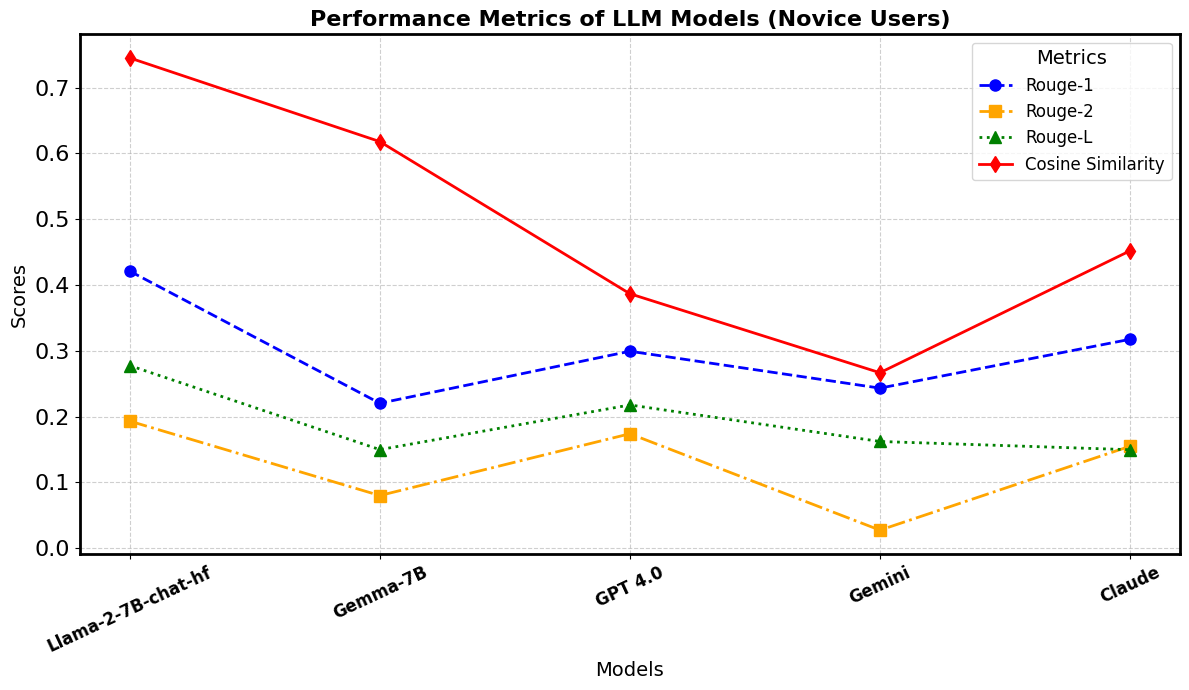

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
models = [
    "Llama-2-7B-chat-hf",
    "Gemma-7B",
    "GPT 4.0",
    "Gemini",
    "Claude"
]
rouge_1 = [0.421052632, 0.220264317, 0.299319728, 0.243243243, 0.317460317]
rouge_2 = [0.193103448, 0.08, 0.173913043, 0.02739726, 0.154897494]
rouge_l = [0.277511962, 0.149779736, 0.217687075, 0.162162162, 0.149659864]
cosine_similarity = [0.745100381, 0.617950258, 0.386706944, 0.266666925, 0.451934346]

# X-axis positions
x = np.arange(len(models))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Plot lines for each metric
ax.plot(models, rouge_1, label="Rouge-1", marker="o", linestyle="--", linewidth=2, markersize=8, color="blue")
ax.plot(models, rouge_2, label="Rouge-2", marker="s", linestyle="-.", linewidth=2, markersize=8, color="orange")
ax.plot(models, rouge_l, label="Rouge-L", marker="^", linestyle=":", linewidth=2, markersize=8, color="green")
ax.plot(models, cosine_similarity, label="Cosine Similarity", marker="d", linestyle="-", linewidth=2, markersize=8, color="red")

# Beautify the plot
ax.set_title("Performance Metrics of LLM Models (Novice Users)", fontsize=16, weight='bold')
ax.set_xlabel("Models", fontsize=14)
ax.set_ylabel("Scores", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=25, fontsize=12, weight='bold')
ax.legend(title="Metrics", fontsize=12, title_fontsize=14)
ax.grid(visible=True, linestyle="--", alpha=0.6)

# Increase y-axis font size and set the font to Arial
ax.tick_params(axis='y', labelsize=16)  # Increase y-axis font size

# Make the boundary of the figure bold
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the boundary line thickness to 2

# Adjust layout for better display
plt.tight_layout()

# Save the figure for research paper
plt.savefig("llm_performance_metrics_experiments_line.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()


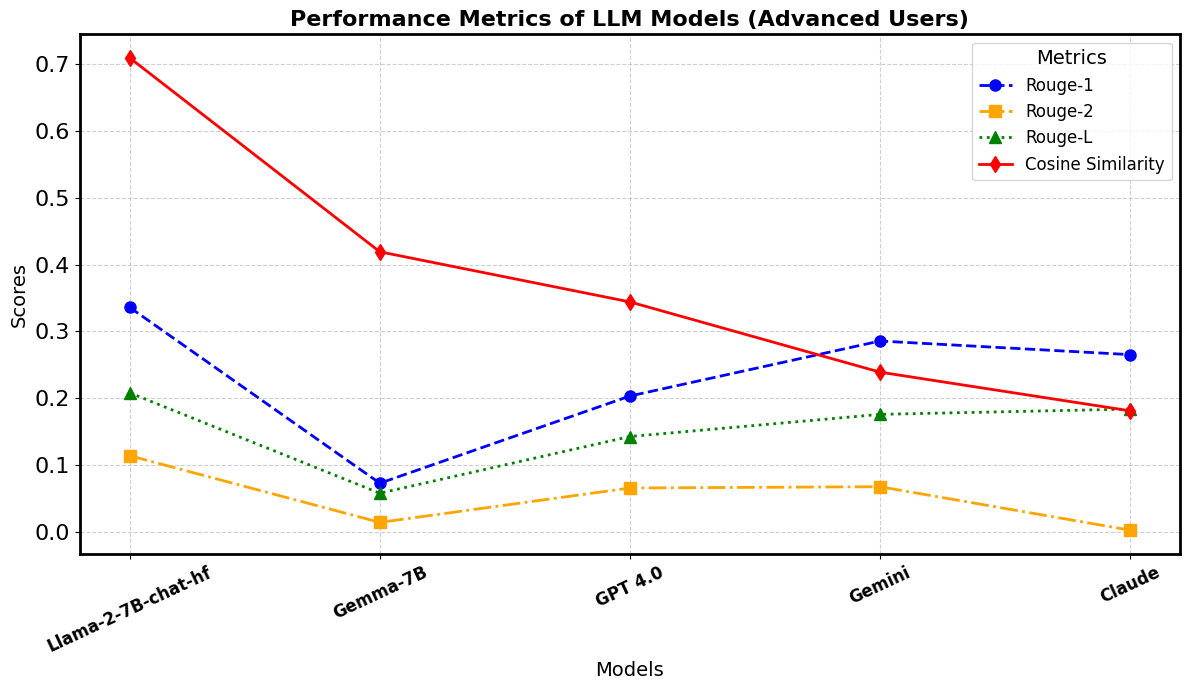

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
models = [
    "Llama-2-7B-chat-hf",
    "Gemma-7B",
    "GPT 4.0",
    "Gemini",
    "Claude"
]
rouge_1 = [0.336, 0.072667289, 0.203270689, 0.285714286, 0.265306122]
rouge_2 = [0.113821138, 0.013954485, 0.065489295, 0.06741573, 0.00234]
rouge_l = [0.208, 0.057660184, 0.142574636, 0.175824176, 0.183673469]
cosine_similarity = [0.709794414, 0.419382737, 0.344293328, 0.239090008, 0.181148547]

# X-axis positions
x = np.arange(len(models))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Plot lines for each metric
ax.plot(models, rouge_1, label="Rouge-1", marker="o", linestyle="--", linewidth=2, markersize=8, color="blue")
ax.plot(models, rouge_2, label="Rouge-2", marker="s", linestyle="-.", linewidth=2, markersize=8, color="orange")
ax.plot(models, rouge_l, label="Rouge-L", marker="^", linestyle=":", linewidth=2, markersize=8, color="green")
ax.plot(models, cosine_similarity, label="Cosine Similarity", marker="d", linestyle="-", linewidth=2, markersize=8, color="red")

# Beautify the plot
ax.set_title("Performance Metrics of LLM Models (Experienced Users)", fontsize=16, weight='bold')
ax.set_xlabel("Models", fontsize=14)
ax.set_ylabel("Scores", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=25, fontsize=12, weight='bold')
ax.legend(title="Metrics", fontsize=12, title_fontsize=14)
ax.grid(visible=True, linestyle="--", alpha=0.6)

# Increase y-axis font size and set the font to Arial
ax.tick_params(axis='y', labelsize=16)  # Increase y-axis font size

# Make the boundary of the figure bold
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the boundary line thickness to 2

# Adjust layout for better display
plt.tight_layout()

# Save the figure for research paper
plt.savefig("llm_performance_metrics_experiments_line.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()


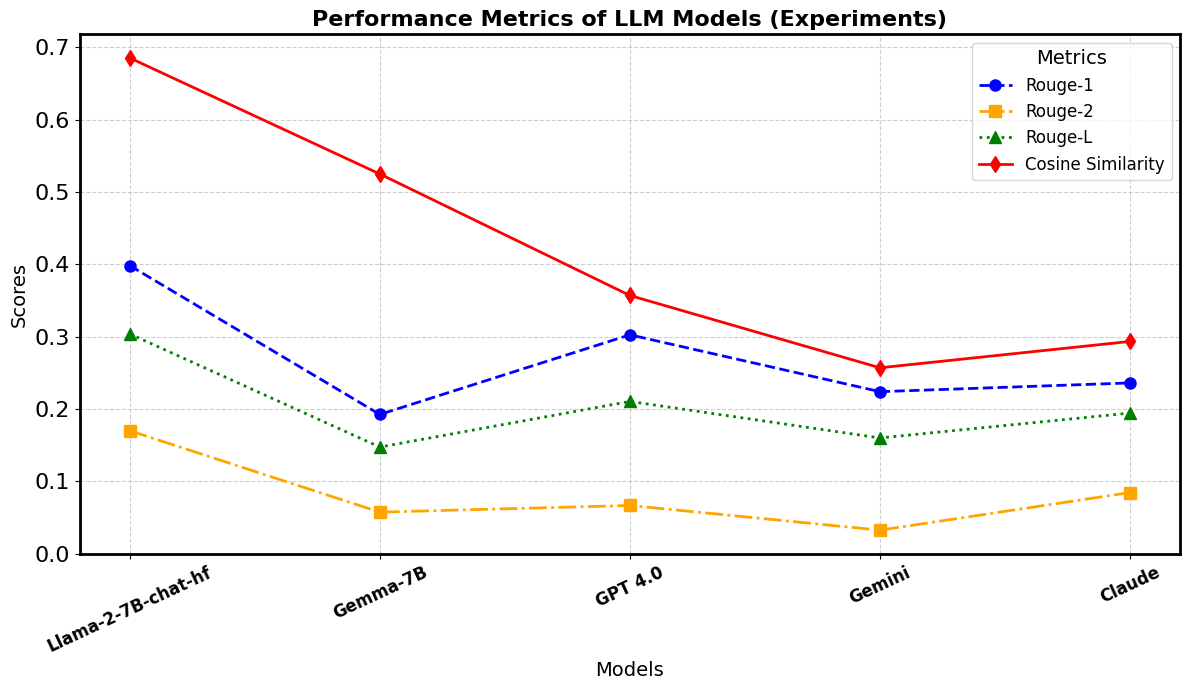

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
models = [
    "Llama-2-7B-chat-hf",
    "Gemma-7B",
    "GPT 4.0",
    "Gemini",
    "Claude"
]
rouge_1 = [0.398317264, 0.192489896, 0.302631579, 0.224, 0.236111111]
rouge_2 = [0.170036808, 0.057416843, 0.066666667, 0.032520325, 0.084507042]
rouge_l = [0.303880956, 0.147379046, 0.210526316, 0.16, 0.194444444]
cosine_similarity = [0.68546298, 0.524970019, 0.357014799, 0.257020511, 0.293470489]

# X-axis positions
x = np.arange(len(models))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Plot lines for each metric
ax.plot(models, rouge_1, label="Rouge-1", marker="o", linestyle="--", linewidth=2, markersize=8, color="blue")
ax.plot(models, rouge_2, label="Rouge-2", marker="s", linestyle="-.", linewidth=2, markersize=8, color="orange")
ax.plot(models, rouge_l, label="Rouge-L", marker="^", linestyle=":", linewidth=2, markersize=8, color="green")
ax.plot(models, cosine_similarity, label="Cosine Similarity", marker="d", linestyle="-", linewidth=2, markersize=8, color="red")

# Beautify the plot
ax.set_title("Performance Metrics of LLM Models (Experiments)", fontsize=16, weight='bold')
ax.set_xlabel("Models", fontsize=14)
ax.set_ylabel("Scores", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=25, fontsize=12, weight='bold')
ax.legend(title="Metrics", fontsize=12, title_fontsize=14)
ax.grid(visible=True, linestyle="--", alpha=0.6)

# Increase y-axis font size and set the font to Arial
ax.tick_params(axis='y', labelsize=16)  # Increase y-axis font size

# Make the boundary of the figure bold
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the boundary line thickness to 2

# Adjust layout for better display
plt.tight_layout()

# Save the figure for research paper
plt.savefig("llm_performance_metrics_experiments_line.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()


# **BAR GRAPHS**

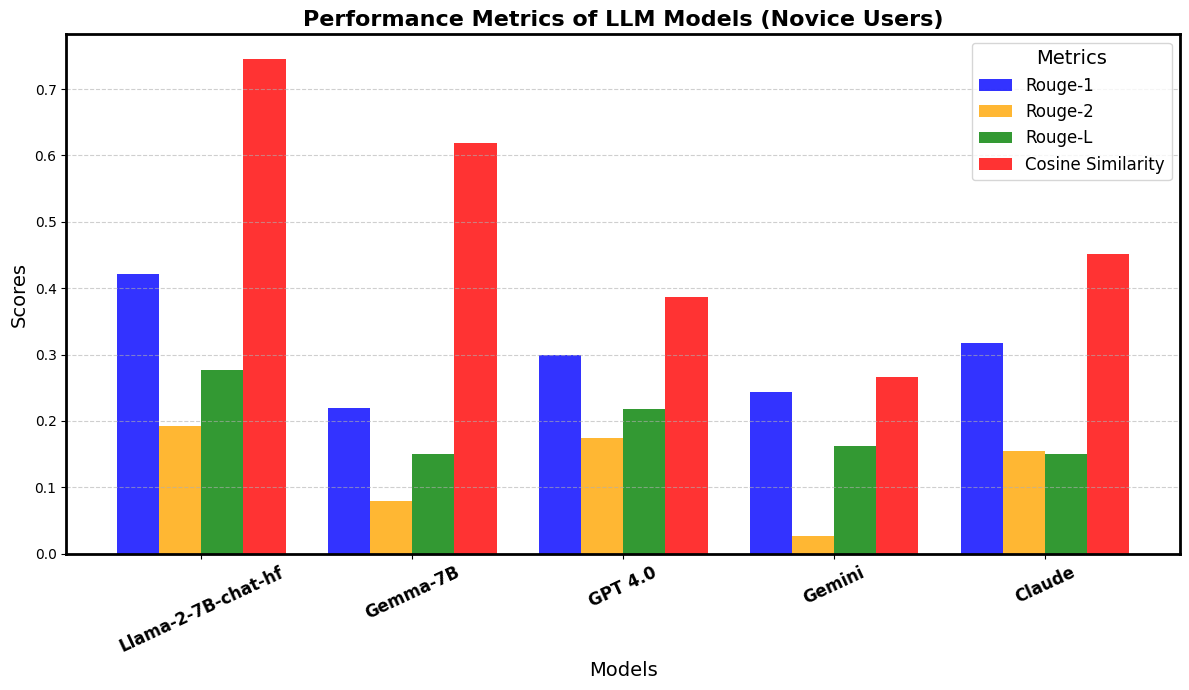

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
models = [
    "Llama-2-7B-chat-hf",
    "Gemma-7B",
    "GPT 4.0",
    "Gemini",
    "Claude"
]
rouge_1 = [0.421052632, 0.220264317, 0.299319728, 0.243243243, 0.317460317]
rouge_2 = [0.193103448, 0.08, 0.173913043, 0.02739726, 0.154897494]
rouge_l = [0.277511962, 0.149779736, 0.217687075, 0.162162162, 0.149659864]
cosine_similarity = [0.745100381, 0.617950258, 0.386706944, 0.266666925, 0.451934346]

# X-axis positions
x = np.arange(len(models))
width = 0.2  # Width of the bars

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Plot bars for each metric
ax.bar(x - 1.5 * width, rouge_1, width, label="Rouge-1", color="blue", alpha=0.8)
ax.bar(x - 0.5 * width, rouge_2, width, label="Rouge-2", color="orange", alpha=0.8)
ax.bar(x + 0.5 * width, rouge_l, width, label="Rouge-L", color="green", alpha=0.8)
ax.bar(x + 1.5 * width, cosine_similarity, width, label="Cosine Similarity", color="red", alpha=0.8)

# Beautify the plot
ax.set_title("Performance Metrics of LLM Models (Novice Users)", fontsize=16, weight='bold')
ax.set_xlabel("Models", fontsize=14)
ax.set_ylabel("Scores", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=25, fontsize=12, weight='bold')
ax.legend(title="Metrics", fontsize=12, title_fontsize=14)
ax.grid(visible=True, linestyle="--", alpha=0.6, axis='y')

# Make the boundary of the figure bold
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the boundary line thickness to 2

# Adjust layout for better display
plt.tight_layout()

# Save the figure for research paper
plt.savefig("llm_performance_metrics_experiments_bar.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()


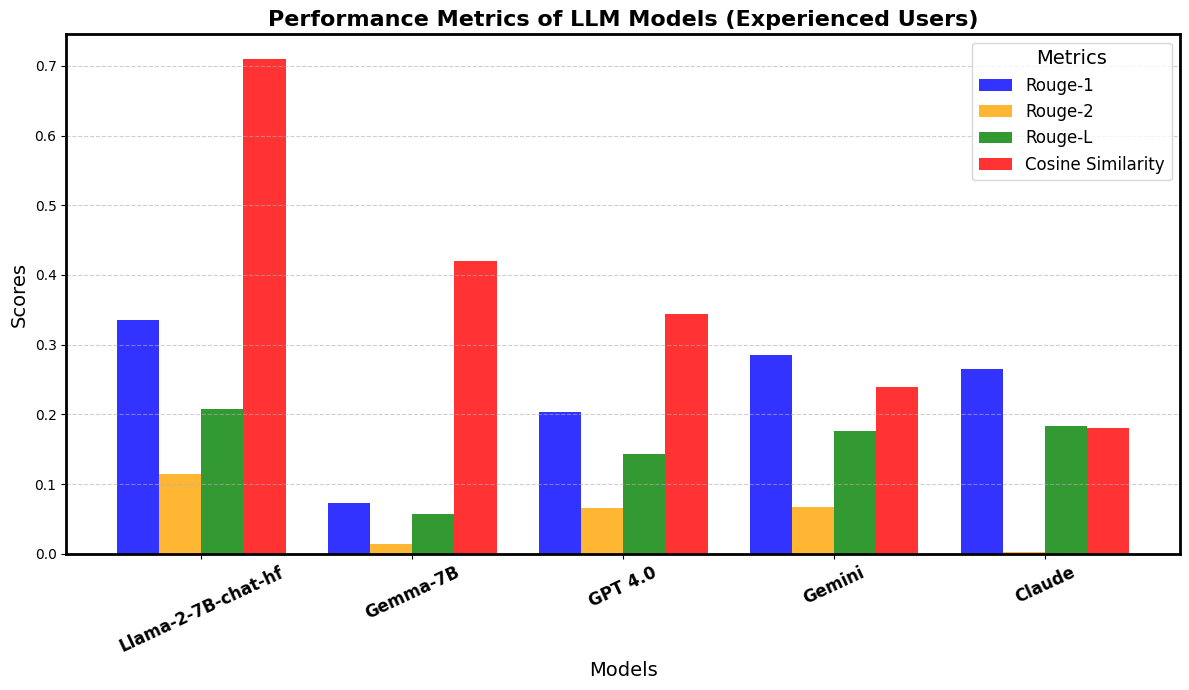

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
models = [
    "Llama-2-7B-chat-hf",
    "Gemma-7B",
    "GPT 4.0",
    "Gemini",
    "Claude"
]
rouge_1 = [0.336, 0.072667289, 0.203270689, 0.285714286, 0.265306122]
rouge_2 = [0.113821138, 0.013954485, 0.065489295, 0.06741573, 0.00234]
rouge_l = [0.208, 0.057660184, 0.142574636, 0.175824176, 0.183673469]
cosine_similarity = [0.709794414, 0.419382737, 0.344293328, 0.239090008, 0.181148547]

# X-axis positions
x = np.arange(len(models))
width = 0.2  # Width of each bar

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Plot bars for each metric
ax.bar(x - 1.5 * width, rouge_1, width, label="Rouge-1", color="blue", alpha=0.8)
ax.bar(x - 0.5 * width, rouge_2, width, label="Rouge-2", color="orange", alpha=0.8)
ax.bar(x + 0.5 * width, rouge_l, width, label="Rouge-L", color="green", alpha=0.8)
ax.bar(x + 1.5 * width, cosine_similarity, width, label="Cosine Similarity", color="red", alpha=0.8)

# Beautify the plot
ax.set_title("Performance Metrics of LLM Models (Experienced Users)", fontsize=16, weight='bold')
ax.set_xlabel("Models", fontsize=14)
ax.set_ylabel("Scores", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=25, fontsize=12, weight='bold')
ax.legend(title="Metrics", fontsize=12, title_fontsize=14)
ax.grid(visible=True, linestyle="--", alpha=0.6, axis='y')

# Make the boundary of the figure bold
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the boundary line thickness to 2

# Adjust layout for better display
plt.tight_layout()

# Save the figure for research paper
plt.savefig("llm_performance_metrics_experiments_bar.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()


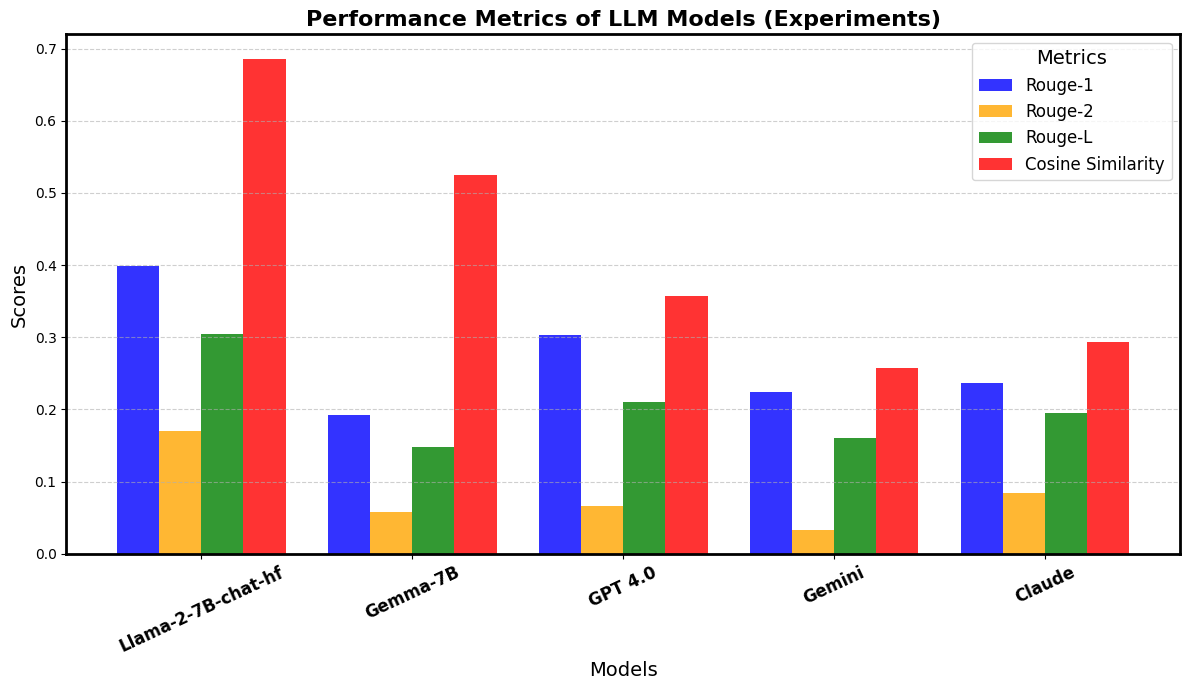

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
models = [
    "Llama-2-7B-chat-hf",
    "Gemma-7B",
    "GPT 4.0",
    "Gemini",
    "Claude"
]
rouge_1 = [0.398317264, 0.192489896, 0.302631579, 0.224, 0.236111111]
rouge_2 = [0.170036808, 0.057416843, 0.066666667, 0.032520325, 0.084507042]
rouge_l = [0.303880956, 0.147379046, 0.210526316, 0.16, 0.194444444]
cosine_similarity = [0.68546298, 0.524970019, 0.357014799, 0.257020511, 0.293470489]

# X-axis positions
x = np.arange(len(models))
width = 0.2  # Width of each bar

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Plot bars for each metric
ax.bar(x - 1.5 * width, rouge_1, width, label="Rouge-1", color="blue", alpha=0.8)
ax.bar(x - 0.5 * width, rouge_2, width, label="Rouge-2", color="orange", alpha=0.8)
ax.bar(x + 0.5 * width, rouge_l, width, label="Rouge-L", color="green", alpha=0.8)
ax.bar(x + 1.5 * width, cosine_similarity, width, label="Cosine Similarity", color="red", alpha=0.8)

# Beautify the plot
ax.set_title("Performance Metrics of LLM Models (Experiments)", fontsize=16, weight='bold')
ax.set_xlabel("Models", fontsize=14)
ax.set_ylabel("Scores", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=25, fontsize=12, weight='bold')
ax.legend(title="Metrics", fontsize=12, title_fontsize=14)
ax.grid(visible=True, linestyle="--", alpha=0.6, axis='y')

# Make the boundary of the figure bold
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Set the boundary line thickness to 2

# Adjust layout for better display
plt.tight_layout()

# Save the figure for research paper
plt.savefig("llm_performance_metrics_experiments_bar.png", dpi=300, bbox_inches="tight")

# Display the plot
plt.show()


In [ ]:
# Data for Cosine Similarity scores
cosine_similarity_scores = [0.68546298, 0.524970019, 0.357014799, 0.257020511, 0.293470489]

# Calculating percentage improvement of Llama-2 over other models
llama_cosine = cosine_similarity_scores[0]
percent_improvement_cosine = [
    ((llama_cosine - score) / score) * 100 for score in cosine_similarity_scores[1:]
]

# Calculate the average percentage improvement for cosine similarity
average_improvement_cosine = sum(percent_improvement_cosine) / len(percent_improvement_cosine)
sum_percent_improvement_cosine = sum(percent_improvement_cosine)
len_percent_improvement_cosine = len(percent_improvement_cosine)

average_improvement_cosine, sum_percent_improvement_cosine, len_percent_improvement_cosine


(105.70937214360944, 422.83748857443777, 4)

0.398317264
0.192489896
0.302631579
0.224
0.236111111

In [ ]:
# Data for Rouge-1 scores
models = ["Llama-2-7B-chat-hf", "Gemma-7B", "GPT 4.0", "Gemini", "Claude"]
rouge_1_scores = [0.398317264, 0.192489896, 0.302631579, 0.224, 0.236111111]

# Calculating percentage improvement of Llama-2 over other models
llama_score = rouge_1_scores[0]
percent_improvement = [
    ((llama_score - score) / score) * 100 for score in rouge_1_scores[1:]
]

# Pairing results with model names for clarity
results = dict(zip(models[1:], percent_improvement))
results

{'Gemma-7B': 106.92892057045947,
 'GPT 4.0': 31.617878516240378,
 'Gemini': 77.82020714285714,
 'Claude': 68.69907659703485}

In [ ]:
# Calculate the average percentage improvement
average_improvement = sum(percent_improvement) / len(percent_improvement)
average_improvement

71.26652070664795

Rouge-1
0.398317264
0.192489896
0.302631579
0.224
0.236111111